In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from scipy.stats import spearmanr

import os

from sklearn.preprocessing import StandardScaler

# For editable text. 
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")
font = {'size' : 20}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}
mpl.rc('font', **font)
mpl.rc('lines', **lines)
mpl.rc('figure', **fig)

/Users/sevahn/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def save_figure_pdf(fig, path_to_save):
	'''
	Utility fxn to save a figure without having to retype all the required options.
	Input:
		fig - a matplotlib.pyplot.figure instance with the figure you'd like to save
		path_to_save - the path you'd like to save the figure to
	Returns: Nothing but there should now be a pdf version in 300 dpi with a transparent bkg at path_to_save
	'''
	fig.savefig(path_to_save, dpi = 300, bbox_inches = 'tight', transparent = True)

In [3]:
data_path = './deconv_fracs_final/'
fig_save_path = '../../../figures/manu_figs/'

In [4]:
basisMatrix = pd.read_csv(f"../../../data/deconvolution_fractions/tsp_v1_basisMatrix.txt",
                         sep = "\t", index_col = 0)

In [5]:
# revise the column space of the basis matrix from Vorperian et al. 

# convert the complex labels fronm the cell type coarsegraining
# to the abbreviations, as presented in the methods

labelConversion = {}


labelConversion["gland cell"] = "acinar cell of salivary gland/myoepithelial cell"
labelConversion["respiratory ciliated cell"] = "ciliated cell/lung ciliated cell"
labelConversion["prostate epithelia"] = "club cell of prostate epithelium/hillock cell of prostate epithelium/hillock-club cell of prostate epithelium"
labelConversion["salivary/bronchial secretory cell"] = "duct epithelial cell/serous cell of epithelium of bronchus"
labelConversion["intestinal enterocyte"] = "enterocyte of epithelium of large intestine/enterocyte of epithelium of small intestine/intestinal crypt stem cell of large intestine/large intestine goblet cell/mature enterocyte/paneth cell of epithelium of large intestine/small intestine goblet cell"
labelConversion["erythrocyte/erythroid progenitor"] = "erythrocyte/erythroid progenitor"
labelConversion["fibroblast/mesenchymal stem cell"] = "fibroblast/mesenchymal stem cell"
labelConversion["intestinal secretory cell"] = "intestinal enteroendocrine cell/paneth cell of epithelium of small intestine/transit amplifying cell of small intestine"
labelConversion["ionocyte/luminal epithelial cell of mammary gland"] = "ionocyte/luminal epithelial cell of mammary gland"
labelConversion["secretory cell"] = "mucus secreting cell/secretory cell/tracheal goblet cell"
labelConversion["pancreatic alpha/beta cell"] = "pancreatic alpha cell/pancreatic beta cell"
labelConversion["respiratory secretory cell"] = "respiratory goblet cell/respiratory mucous cell/serous cell of epithelium of trachea"
labelConversion["basal prostate cell"] = "basal cell of prostate epithelia"
labelConversion["intestinal crypt stem cell"] = "immature enterocyte/intestinal crypt stem cell/intestinal crypt stem cell of small intestine/transit amplifying cell of large intestine"
    
revLabs = {}
for l in labelConversion:
    revLabs[labelConversion[l]] = l

    
cg_celltypes = []
for i in basisMatrix.columns:
    if i in revLabs.keys():
        cg_celltypes += [revLabs[i]]
    else: cg_celltypes += [i]
        
# capitalize everything for aesthetics
cg_celltypes = [i.capitalize() for i in cg_celltypes]
basisMatrix.columns = cg_celltypes

In [6]:
# get all the gene predictions
preds_sherlock = pd.read_csv(f'../../../data/deconvolution_fractions/pee_repool_final_preds__20230517.csv',
                         index_col = 0)

ground_truth_labs = [i for i in preds_sherlock.columns if 'ground_truth' in i]
ground_truths = preds_sherlock.loc[:, ground_truth_labs]
ground_truths.columns = [i.split("ground_truth_")[1].split("-NUSVR")[0] for i in ground_truths]



sample_id = [i.split("-NUSVR")[0] for i in preds_sherlock.columns if 'ground_truth' not in i]
samples = [i for i in preds_sherlock.columns if 'ground_truth' not in i]
genes = preds_sherlock.index

In [7]:
# males
urine_meta = pd.read_csv("../../../data/diffex/urine_only_meta_diffex.csv",
                        sep = ",", index_col = 0)

males = urine_meta[urine_meta.sex == 1].index.tolist()
males = np.unique(males)

male_samps = []
for male_patient in males:
    for sample in sample_id:
        if male_patient in sample:
            male_samps += [sample]

In [8]:
len([i for i in male_samps if 'supt' in i])

11

In [9]:
len([i for i in male_samps if 'supt' in i]) - 5

6

In [10]:
allPreds = pd.DataFrame()
sed_mispreds = {}
supt_mispreds = {}

sd_thresh = 2

for s in male_samps:
        
    subset = [i for i in preds_sherlock.columns if s in i]

    # compute the squared error
    preds = preds_sherlock[subset].dropna(how = 'any')
    preds['residual_squared'] = (preds.iloc[:, 0] - preds.iloc[:, 1]) ** 2 
    
    # get genes with |predicted gene expression residual| >= 2 * SD
    residuals = np.asarray(preds.residual_squared.values.tolist())
    std = np.std(residuals)
    mean = np.mean(residuals)
    mask = np.abs(residuals - mean) > (std * sd_thresh)
    
    # list of genes with the bad predictions
    poor_predictions = preds.loc[mask].index.tolist()
    
    # get associated gene expression value
    top_genes = preds.loc[poor_predictions]
    
    #poor_predictions = top_genes[np.abs(top_genes[f'{s}_se']) >= very_high][f'{s}_gene'].tolist()
    if 'sediment' in s:
        sed_mispreds[s] = poor_predictions
    elif 'supt' in s:
        supt_mispreds[s] = poor_predictions



    allPreds = pd.concat([allPreds, top_genes], axis = 1)

In [11]:
stone_sed_mispred = [sed_mispreds[k] for k in sed_mispreds if k[0] != 'N']

# get the set of genes
stone_sed_mispred = list(set([j for i in stone_sed_mispred for j in i]))

In [12]:
stone_supt_mispred = [supt_mispreds[k] for k in supt_mispreds if k[0] != 'N']

# get the set of genes
stone_supt_mispred = list(set([j for i in stone_supt_mispred for j in i]))

In [13]:
normal_supt_mispred = [supt_mispreds[k] for k in supt_mispreds if k[0] == 'N']

# get the set of genes
normal_supt_mispred = list(set([j for i in normal_supt_mispred for j in i]))

In [14]:
len([i for i in list(supt_mispreds.keys()) if i[0] == 'N'])

5

In [15]:
len([i for i in list(supt_mispreds.keys()) if i[0] != 'N'])

6

In [16]:
top_mispredicted = basisMatrix.loc[stone_supt_mispred]

sc = StandardScaler()
mispred_zscore = sc.fit_transform(top_mispredicted.values.T)
mispred_zscore = pd.DataFrame(mispred_zscore)
mispred_zscore.index = top_mispredicted.columns
mispred_zscore.columns = top_mispredicted.index

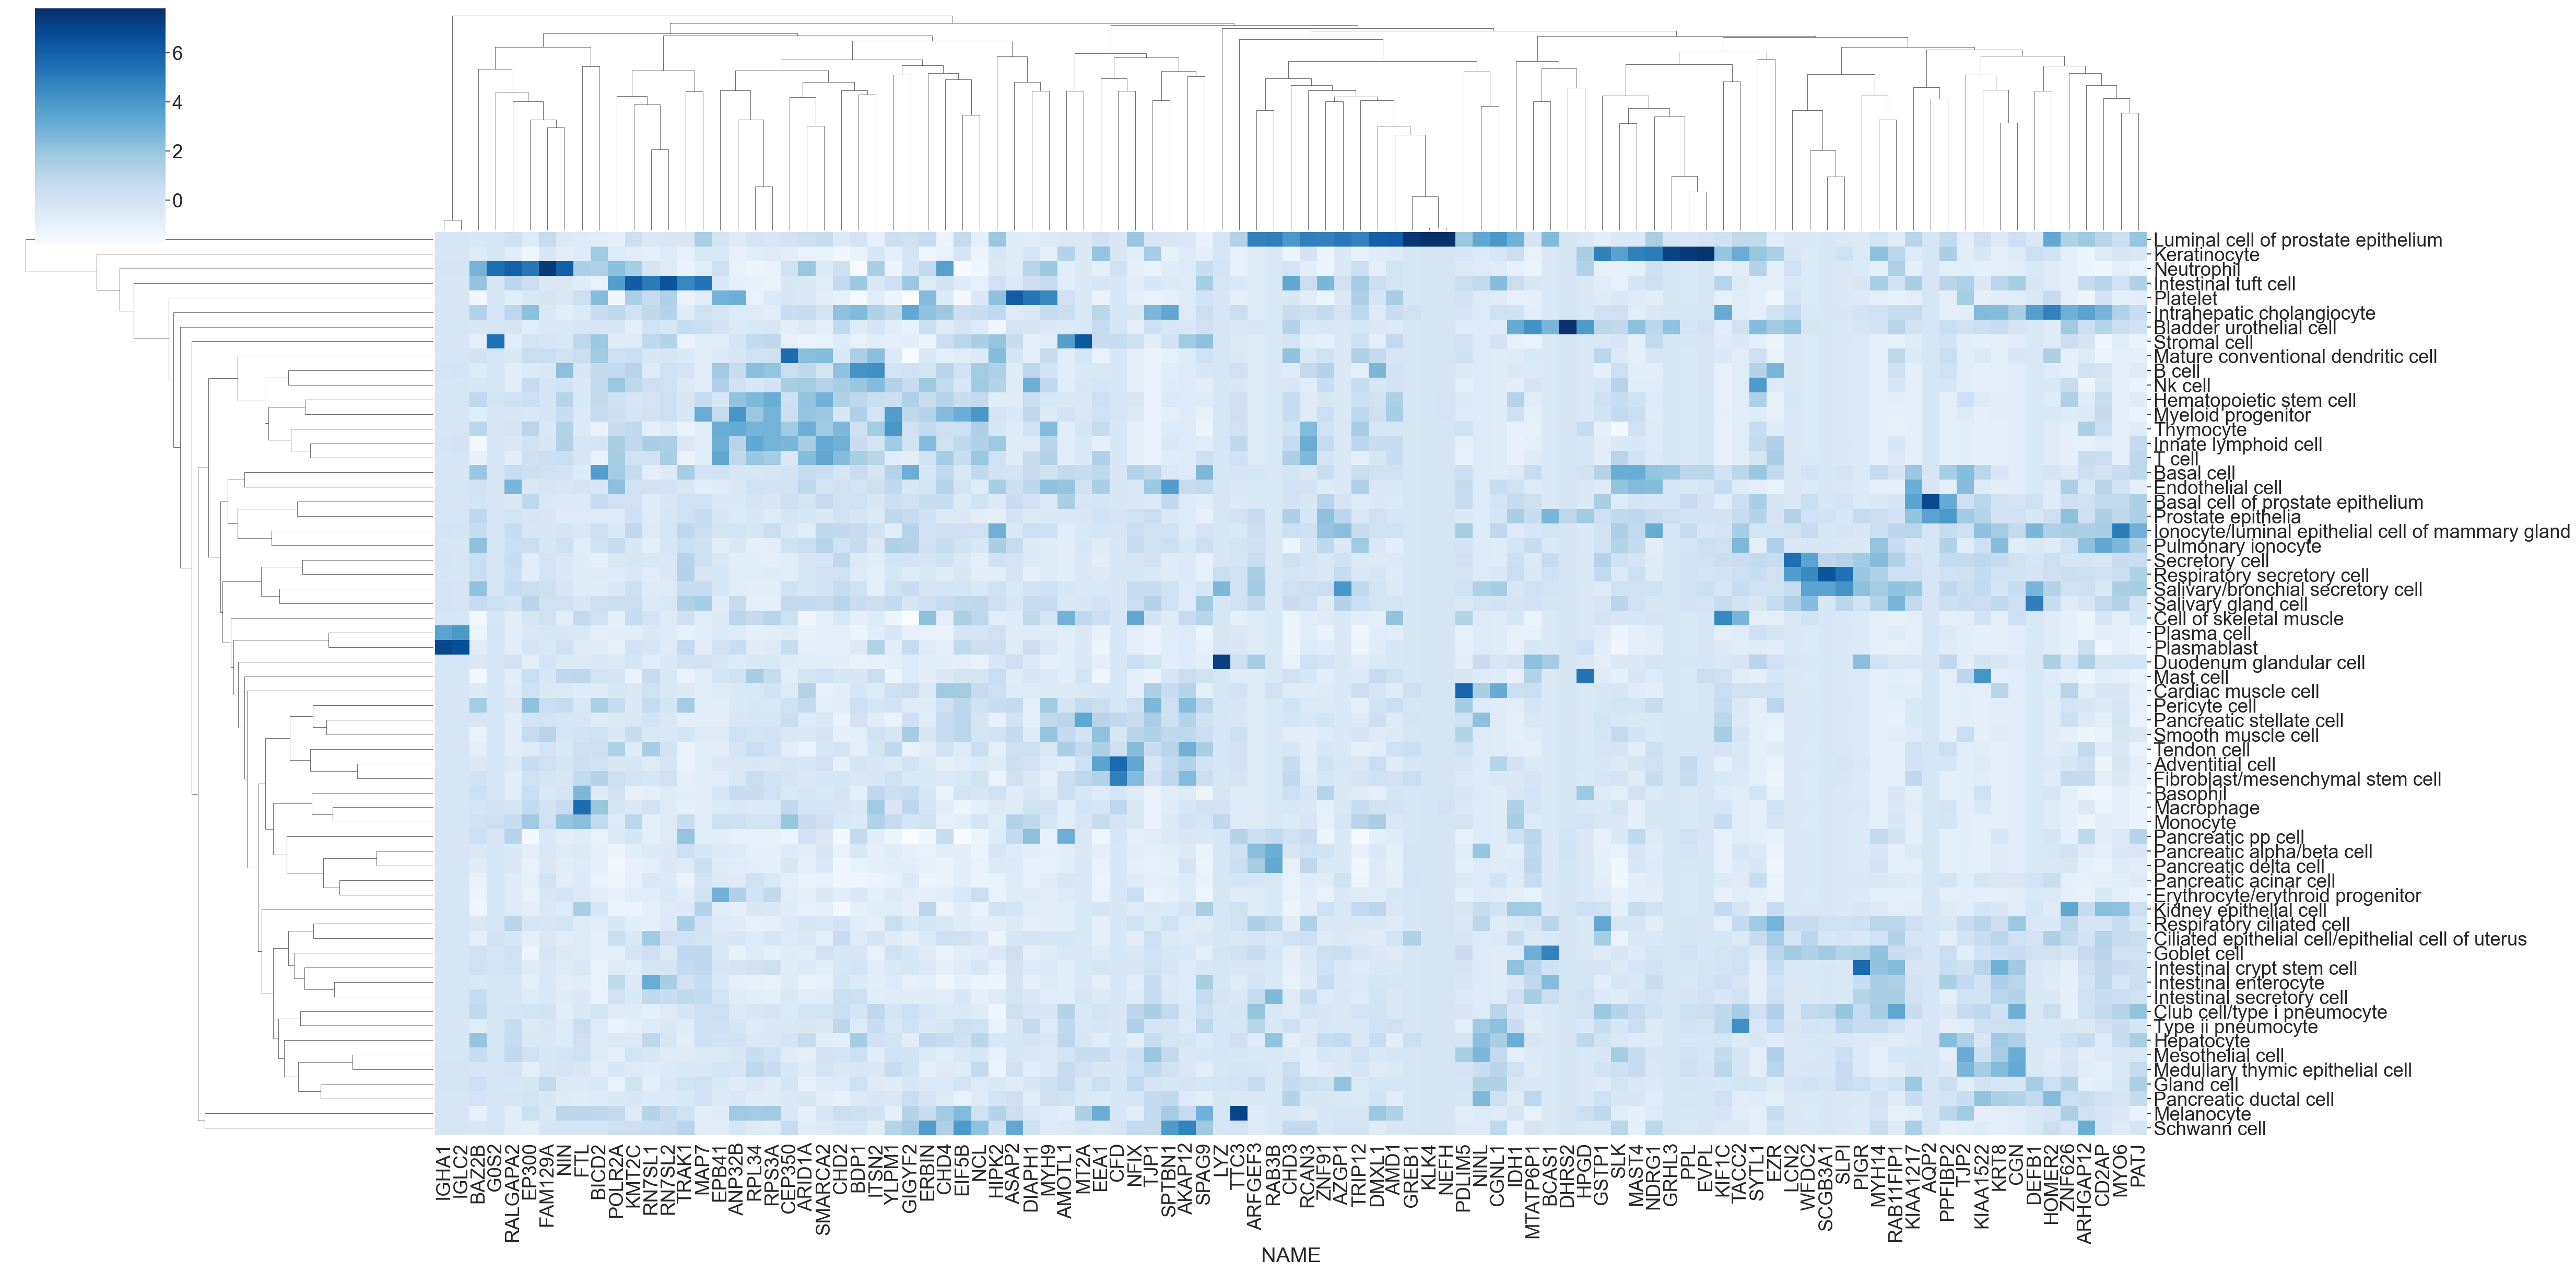

In [17]:
sns.set(font_scale = 2.4)

sns.clustermap(mispred_zscore,
              yticklabels = True,
               xticklabels = True,
              figsize = (50, 25),
               annot_kws={'size': 20},
               
            cmap = 'Blues')

plt.xlabel("");


save_figure_pdf(plt, f'{fig_save_path}stone_supt_deconv_err.pdf')

In [18]:
top_mispredicted_hc = basisMatrix.loc[normal_supt_mispred]

sc = StandardScaler()
mispred_zscore = sc.fit_transform(top_mispredicted_hc.values.T)
mispred_zscore = pd.DataFrame(mispred_zscore)
mispred_zscore.index = top_mispredicted_hc.columns
mispred_zscore.columns = top_mispredicted_hc.index

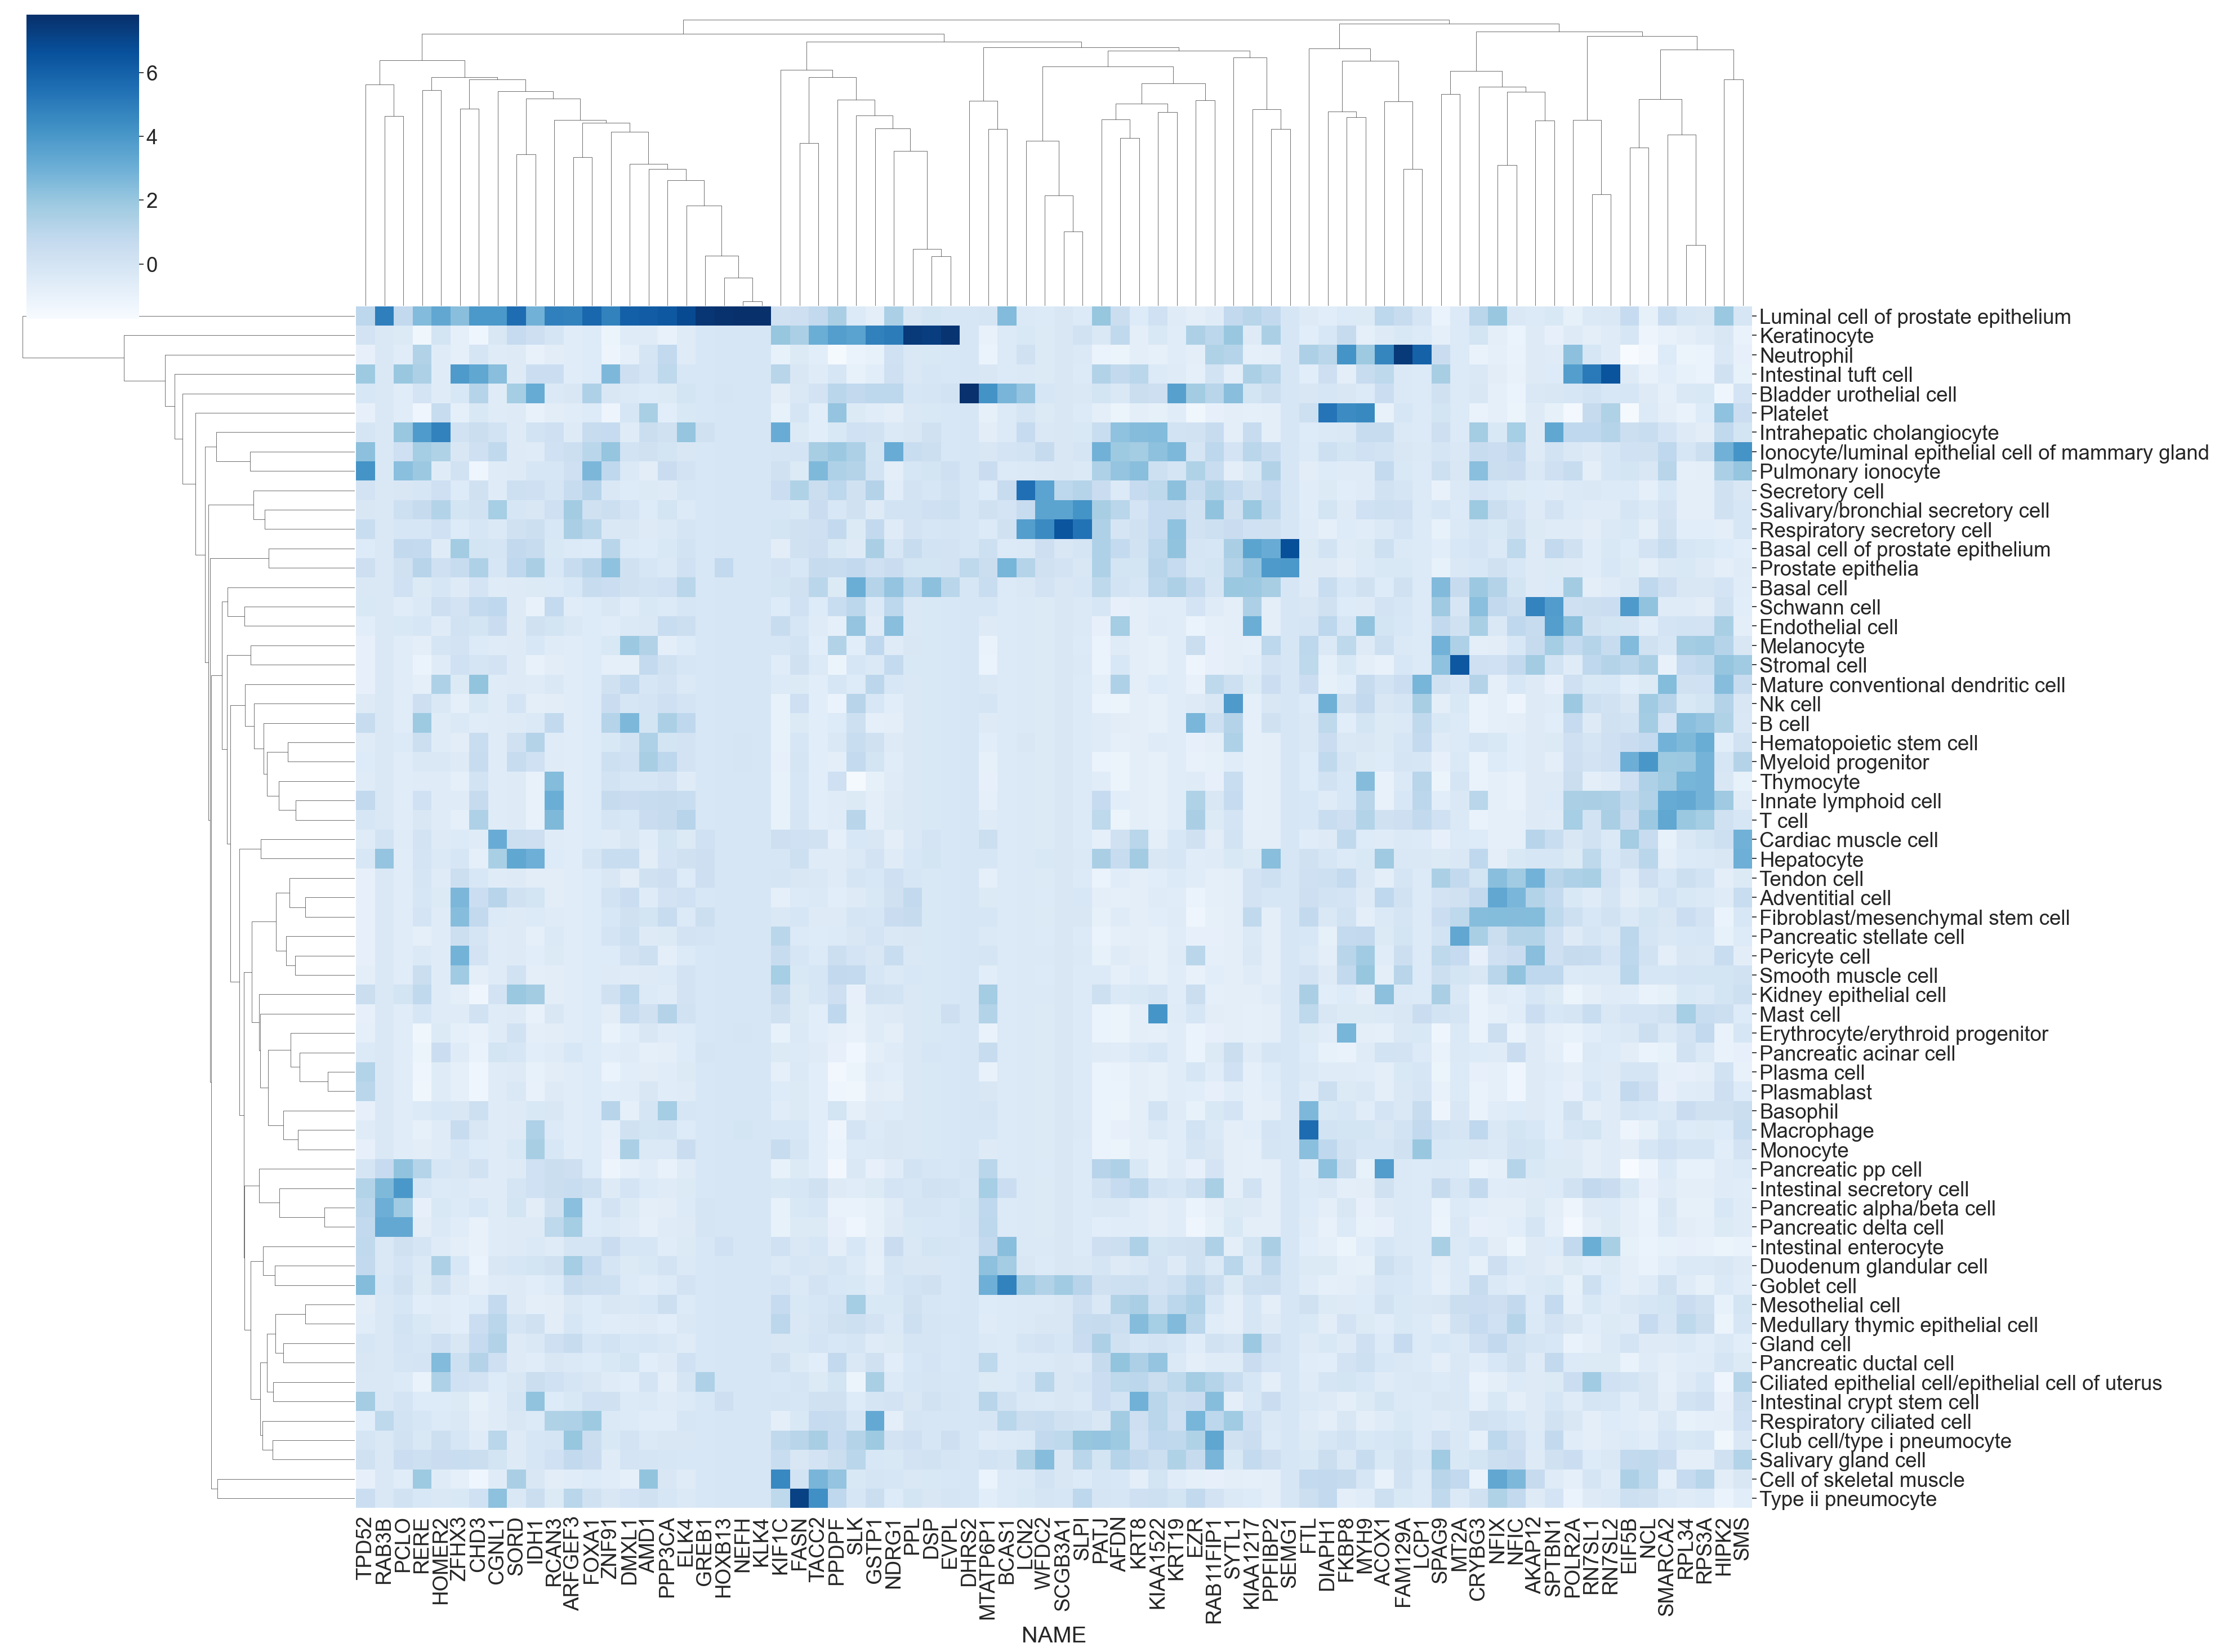

In [19]:
sns.set(font_scale = 2.4)

sns.clustermap(mispred_zscore,
              yticklabels = True,
               xticklabels = True,
              figsize = (40, 30),
               annot_kws={'size': 25},
               
            cmap = 'Blues')

plt.xlabel("");


save_figure_pdf(plt, f'{fig_save_path}normal_supt_deconv_err.pdf')